Exploratory Data Analysis 

In [1]:
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table, show_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, style_dataframe
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot, df_to_pdf, plot_to_pdf
from utilities_widgets import position_chart
from utilities_IO import output_html
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    file = re.sub(r'\W', '_', glob.tooling)
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('TOP_PASSAT_B9_…

Table *TOP_PASSAT_B9_Measurements_2024y_08m_09d_11h_42m_40s* retrieved succesfully.
Table *TOP_PASSAT_B9_Limits_2024y_08m_09d_11h_42m_40s* retrieved succesfully.
Table *TOP_PASSAT_B9_FixtureData_2024y_08m_09d_13h_14m_06s* retrieved succesfully.


In [4]:
##Database management
print(f"File(s) ready to use:")
for table in tables.value:
    print(f"    {table}")

File(s) ready to use:
    TOP_PASSAT_B9_Measurements_2024y_08m_09d_11h_42m_40s
    TOP_PASSAT_B9_Limits_2024y_08m_09d_11h_42m_40s
    TOP_PASSAT_B9_FixtureData_2024y_08m_09d_13h_14m_06s


In [5]:
#Fixture metadata preparation
if "FIXTURE_DATA" not in globals(): #Gets data directly from the globals file
    FIXTURE_DATA = pd.DataFrame.from_records([glob.__dict__]).transpose()
    FIXTURE_DATA.rename(columns={0:"Tooling data"}, inplace=True)
    FIXTURE_DATA.rename(index={"tooling": "Tooling name", "lenses_per_nest": "Lenses per nest", "nests_number": "Number of nests", "x_tolerance":"X-axis tolerance",
                            "y_tolerance":"Y-axis tolerance", "lo_tolerance":"Lower tolerance", "hi_tolerance": "Higher tolerance"}, inplace=True)
print("Fixture metadata:")
display(FIXTURE_DATA)

Fixture metadata:


,Tooling data
Tooling name,TOP_PASSAT_B9
Lenses per nest,3
Number of nests,4
X-axis tolerance,0.0125
Y-axis tolerance,0.0165
Lower tolerance,0.02
Higher tolerance,0.03


In [6]:
##Measurements preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 21,test: 22,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30
Guia_Luz_Blanco_FB1_X,0.3511,0.3487,0.3505,0.3546,0.3360,0.3253,0.3265,0.3566,0.3550,0.3542,...,0.3585,0.3576,0.3548,0.3575,0.3245,0.3588,0.3592,0.3540,0.3538,0.3579
Guia_Luz_Blanco_FB1_Y,0.3619,0.3612,0.3617,0.3625,0.3572,0.3546,0.3550,0.3625,0.3625,0.3630,...,0.3639,0.3636,0.3629,0.3636,0.3540,0.3637,0.3642,0.3625,0.3625,0.3635
Guia_Luz_Blanco_FB2_X,0.3333,0.3482,0.3326,0.3349,0.3328,0.3298,0.3320,0.3352,0.3351,0.3375,...,0.3366,0.3361,0.3357,0.3359,0.3296,0.3366,0.3364,0.3350,0.3352,0.3363
Guia_Luz_Blanco_FB2_Y,0.3566,0.3579,0.3565,0.3578,0.3570,0.3566,0.3580,0.3575,0.3578,0.3601,...,0.3591,0.3591,0.3581,0.3591,0.3564,0.3589,0.3589,0.3580,0.3579,0.3590
Guia_Luz_Blanco_FB3_X,0.3430,0.3442,0.3442,0.3423,0.3422,0.3434,0.3425,0.3419,0.3417,0.3457,...,0.3431,0.3419,0.3424,0.3419,0.3417,0.3423,0.3425,0.3441,0.3436,0.3422
Guia_Luz_Blanco_FB3_Y,0.3695,0.3697,0.3699,0.3686,0.3686,0.3695,0.3684,0.3678,0.3684,0.3715,...,0.3692,0.3681,0.3684,0.3683,0.3684,0.3687,0.3684,0.3697,0.3696,0.3686
Guia_Luz_Blanco_FB4_X,0.3537,0.3548,0.3551,0.3505,0.3379,0.3275,0.3277,0.3509,0.3512,0.3512,...,0.3545,0.3545,0.3568,0.3540,0.3258,0.3541,0.3546,0.3568,0.3546,0.3578
Guia_Luz_Blanco_FB4_Y,0.3601,0.3600,0.3600,0.3596,0.3564,0.3552,0.3553,0.3595,0.3595,0.3596,...,0.3601,0.3600,0.3605,0.3599,0.3541,0.3599,0.3600,0.3604,0.3600,0.3603
Guia_Luz_Blanco_FB5_X,0.3348,0.3349,0.3348,0.3342,0.3337,0.3325,0.3310,0.3350,0.3346,0.3353,...,0.3361,0.3355,0.3361,0.3359,0.3315,0.3362,0.3365,0.3364,0.3352,0.3369
Guia_Luz_Blanco_FB5_Y,0.3594,0.3590,0.3589,0.3587,0.3598,0.3597,0.3587,0.3591,0.3587,0.3591,...,0.3599,0.3596,0.3600,0.3598,0.3588,0.3598,0.3599,0.3602,0.3600,0.3595


In [7]:
##Limits preparation
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("Limits:")
display(LIMITS_format)

Limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.325,0.345
Guia_Luz_Blanco_FB3_Y,0.340,0.368
Guia_Luz_Blanco_FB4_X,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.325,0.358


In [8]:
##Test results visualization
DATA_format = pd.concat([MEAS_format, LIMITS_format], axis=1)
DATA_FILTERED = style_dataframe(DATA_format, LIMITS_format) # Apply conditional formatting with row-specific limits
display(DATA_FILTERED)

,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,test: 11,test: 12,test: 13,test: 14,test: 15,test: 16,test: 17,test: 18,test: 19,test: 20,test: 21,test: 22,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.351100,0.348700,0.350500,0.354600,0.336000,0.325300,0.326500,0.356600,0.355000,0.354200,0.354900,0.356500,0.357100,0.355200,0.354400,0.354900,0.355300,0.356900,0.356600,0.357400,0.358500,0.357600,0.354800,0.357500,0.324500,0.358800,0.359200,0.354000,0.353800,0.357900,0.310000,0.335000
Guia_Luz_Blanco_FB1_Y,0.361900,0.361200,0.361700,0.362500,0.357200,0.354600,0.355000,0.362500,0.362500,0.363000,0.362700,0.363100,0.362700,0.362700,0.362800,0.362600,0.362800,0.363700,0.363700,0.363600,0.363900,0.363600,0.362900,0.363600,0.354000,0.363700,0.364200,0.362500,0.362500,0.363500,0.325000,0.358000
Guia_Luz_Blanco_FB2_X,0.333300,0.348200,0.332600,0.334900,0.332800,0.329800,0.332000,0.335200,0.335100,0.337500,0.335600,0.335400,0.335400,0.335300,0.335400,0.335300,0.335200,0.336200,0.336200,0.336700,0.336600,0.336100,0.335700,0.335900,0.329600,0.336600,0.336400,0.335000,0.335200,0.336300,0.310000,0.335000
Guia_Luz_Blanco_FB2_Y,0.356600,0.357900,0.356500,0.357800,0.357000,0.356600,0.358000,0.357500,0.357800,0.360100,0.358200,0.357900,0.357300,0.357900,0.358100,0.357900,0.357900,0.358900,0.358300,0.359300,0.359100,0.359100,0.358100,0.359100,0.356400,0.358900,0.358900,0.358000,0.357900,0.359000,0.325000,0.358000
Guia_Luz_Blanco_FB3_X,0.343000,0.344200,0.344200,0.342300,0.342200,0.343400,0.342500,0.341900,0.341700,0.345700,0.344000,0.342100,0.343200,0.344400,0.343700,0.343600,0.341900,0.341700,0.342100,0.341900,0.343100,0.341900,0.342400,0.341900,0.341700,0.342300,0.342500,0.344100,0.343600,0.342200,0.325000,0.345000
Guia_Luz_Blanco_FB3_Y,0.369500,0.369700,0.369900,0.368600,0.368600,0.369500,0.368400,0.367800,0.368400,0.371500,0.369500,0.368700,0.368800,0.369800,0.369500,0.369600,0.368300,0.368400,0.368700,0.368100,0.369200,0.368100,0.368400,0.368300,0.368400,0.368700,0.368400,0.369700,0.369600,0.368600,0.340000,0.368000
Guia_Luz_Blanco_FB4_X,0.353700,0.354800,0.355100,0.350500,0.337900,0.327500,0.327700,0.350900,0.351200,0.351200,0.351000,0.351800,0.351600,0.351800,0.351400,0.351300,0.351500,0.352300,0.356800,0.355500,0.354500,0.354500,0.356800,0.354000,0.325800,0.354100,0.354600,0.356800,0.354600,0.357800,0.310000,0.335000
Guia_Luz_Blanco_FB4_Y,0.360100,0.360000,0.360000,0.359600,0.356400,0.355200,0.355300,0.359500,0.359500,0.359600,0.359600,0.360000,0.359500,0.359600,0.359500,0.359500,0.359500,0.360100,0.360500,0.360300,0.360100,0.360000,0.360500,0.359900,0.354100,0.359900,0.360000,0.360400,0.360000,0.360300,0.325000,0.358000
Guia_Luz_Blanco_FB5_X,0.334800,0.334900,0.334800,0.334200,0.333700,0.332500,0.331000,0.335000,0.334600,0.335300,0.335400,0.334600,0.335300,0.334700,0.334900,0.334800,0.335100,0.336200,0.336800,0.336400,0.336100,0.335500,0.336100,0.335900,0.331500,0.336200,0.336500,0.336400,0.335200,0.336900,0.310000,0.335000
Guia_Luz_Blanco_FB5_Y,0.359400,0.359000,0.358900,0.358700,0.359800,0.359700,0.358700,0.359100,0.358700,0.359100,0.359100,0.358600,0.359000,0.358600,0.359100,0.358800,0.359000,0.360100,0.360500,0.359800,0.359900,0.359600,0.360000,0.359800,0.358800,0.359800,0.359900,0.360200,0.360000,0.359500,0.325000,0.358000


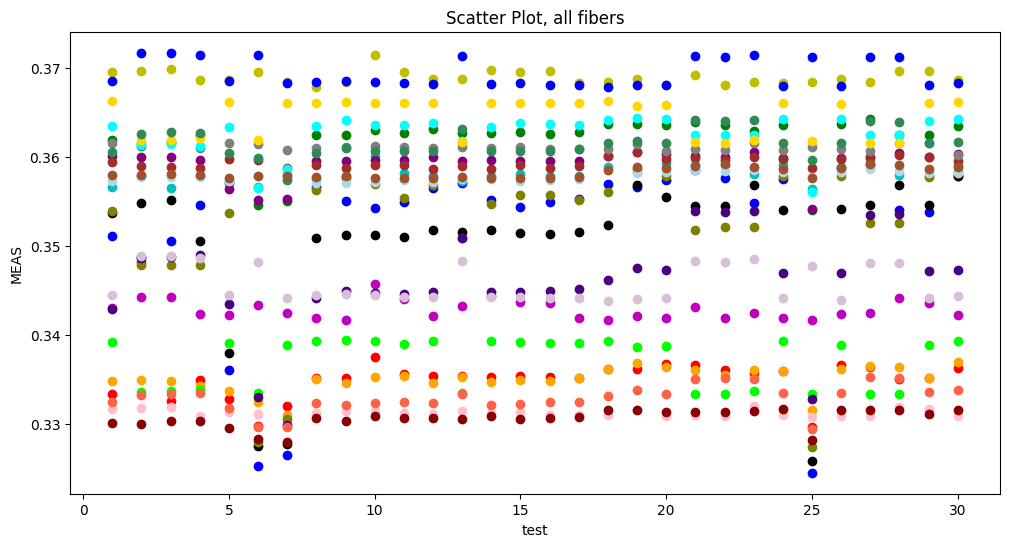

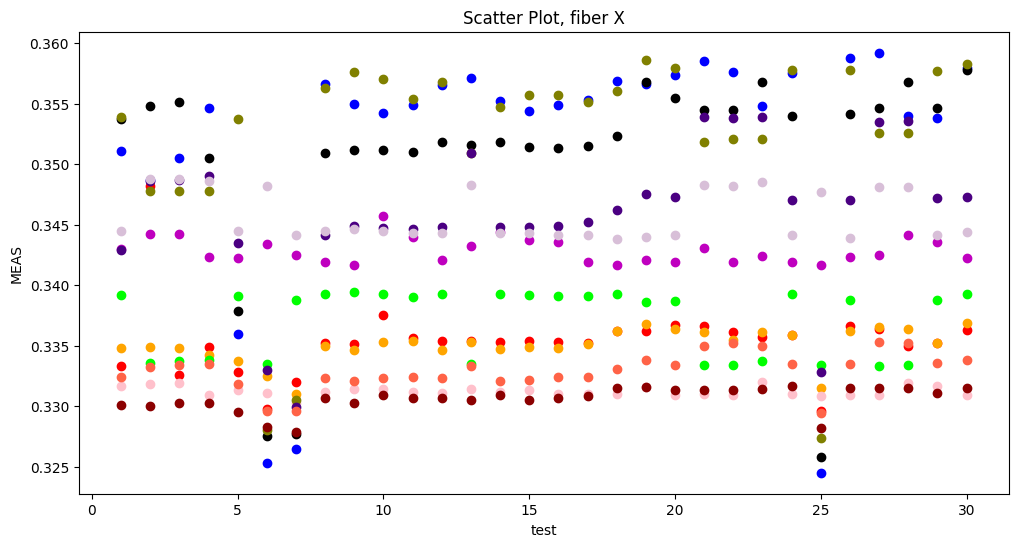

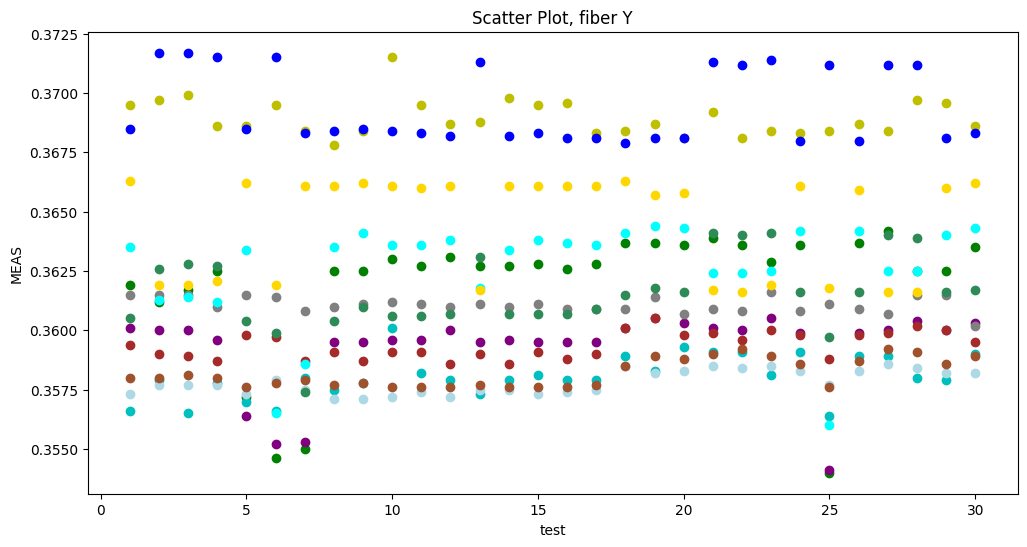

In [9]:
##Visualizations
fig = plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
fig = plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
fig = plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [10]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,30.0,0.351810,0.009907,0.3245,0.353850,0.35495,0.357050,0.3592
Guia_Luz_Blanco_FB1_Y,30.0,0.361897,0.002789,0.3540,0.362500,0.36270,0.363575,0.3642
Guia_Luz_Blanco_FB2_X,30.0,0.335383,0.003068,0.3296,0.335025,0.33540,0.336200,0.3482
Guia_Luz_Blanco_FB2_Y,30.0,0.358067,0.000906,0.3564,0.357800,0.35795,0.358900,0.3601
Guia_Luz_Blanco_FB3_X,30.0,0.342847,0.001032,0.3417,0.341950,0.34245,0.343600,0.3457
Guia_Luz_Blanco_FB3_Y,30.0,0.368957,0.000774,0.3678,0.368400,0.36870,0.369500,0.3715
Guia_Luz_Blanco_FB4_X,30.0,0.350300,0.008643,0.3258,0.351200,0.35205,0.354600,0.3578
Guia_Luz_Blanco_FB4_Y,30.0,0.359283,0.001666,0.3541,0.359500,0.35990,0.360075,0.3605
Guia_Luz_Blanco_FB5_X,30.0,0.335043,0.001403,0.3310,0.334725,0.33515,0.336100,0.3369
Guia_Luz_Blanco_FB5_Y,30.0,0.359373,0.000553,0.3586,0.358925,0.35925,0.359800,0.3605


Analysis of faulty fibers

In [11]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Adds an absolute fiber number for quick identification
LARGEST = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filters the 5 largest values
display(LARGEST)

,std,Fiber number
Guia_Luz_Blanco_FB1_X,0.009907,1
Guia_Luz_Blanco_FB4_X,0.008643,7
Guia_Luz_Blanco_FB7_X,0.008494,13
Guia_Luz_Blanco_FB10_X,0.005839,19
Guia_Luz_Blanco_FB2_X,0.003068,3


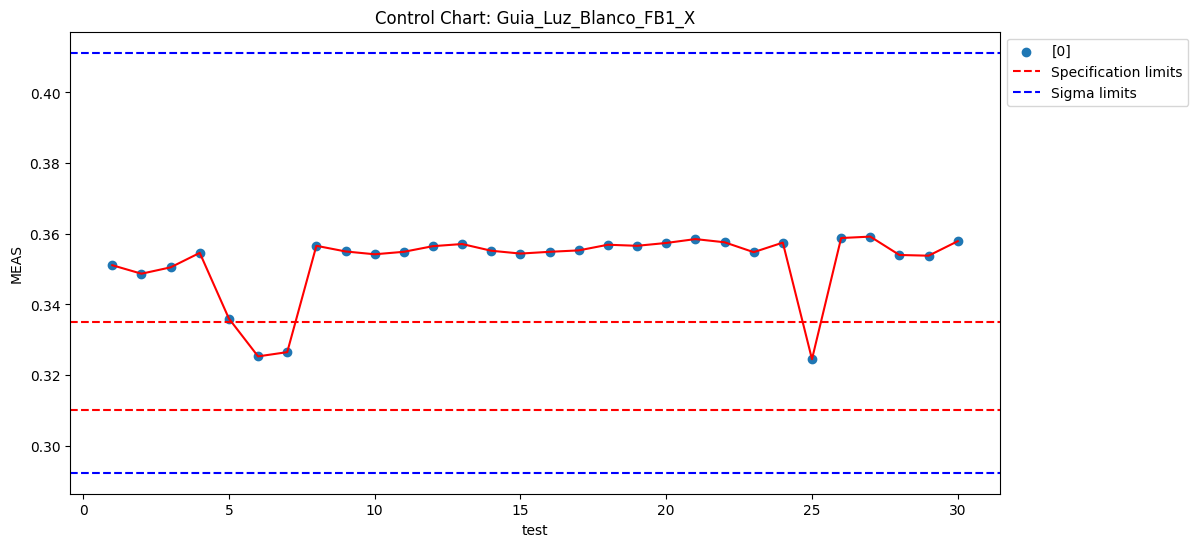

In [17]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title=f'Control Chart: {fiber_selection.value}', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

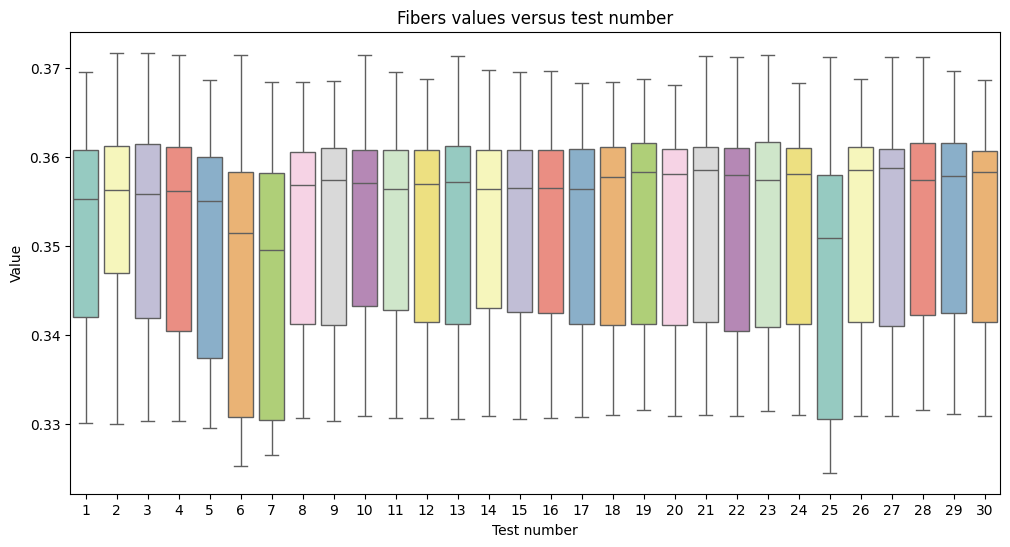

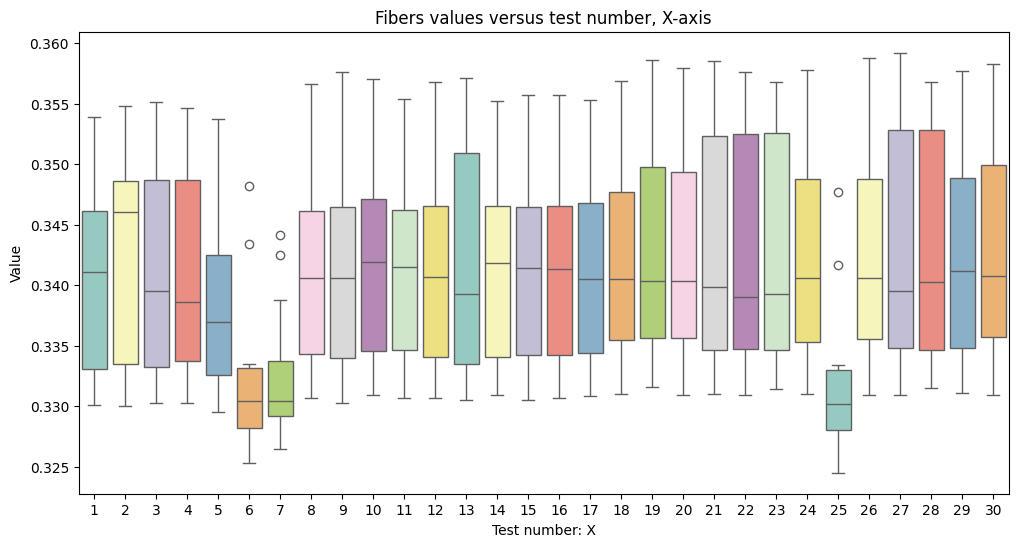

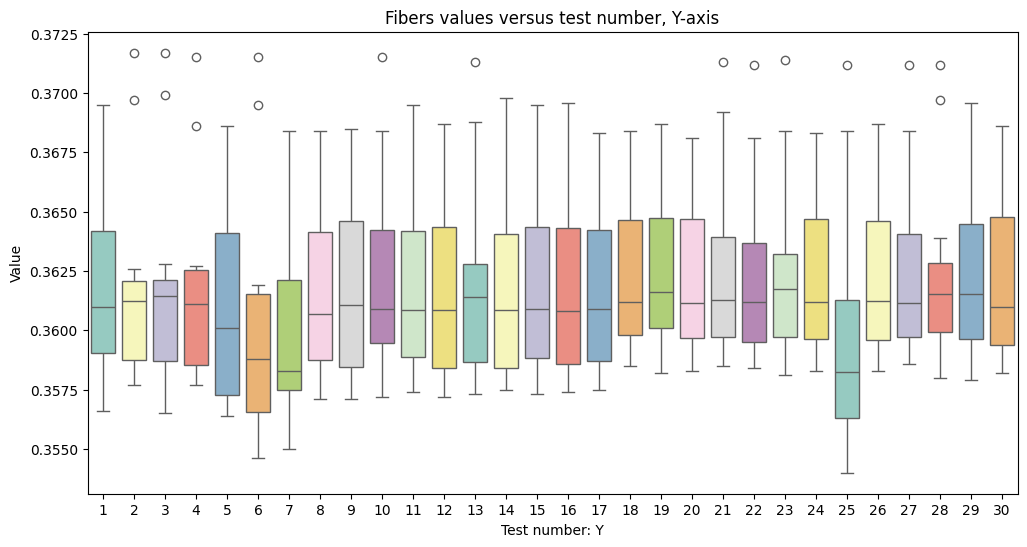

In [15]:
##Boxplot visualization
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number", xlabel="Test number", ylabel="Value", filter=None)
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, X-axis", xlabel="Test number: ", ylabel="Value", filter="X")
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, Y-axis", xlabel="Test number: ", ylabel="Value", filter="Y")
#fig = plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

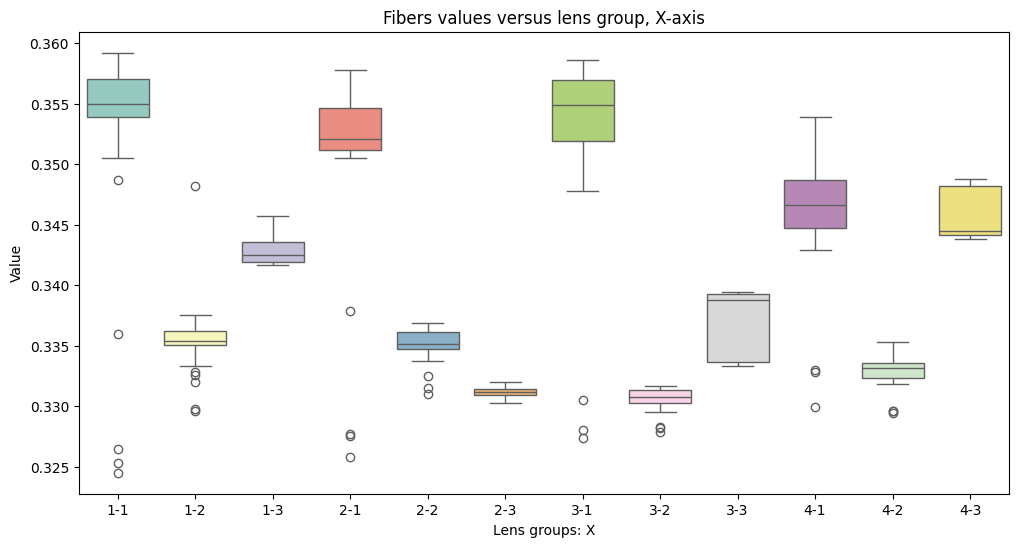

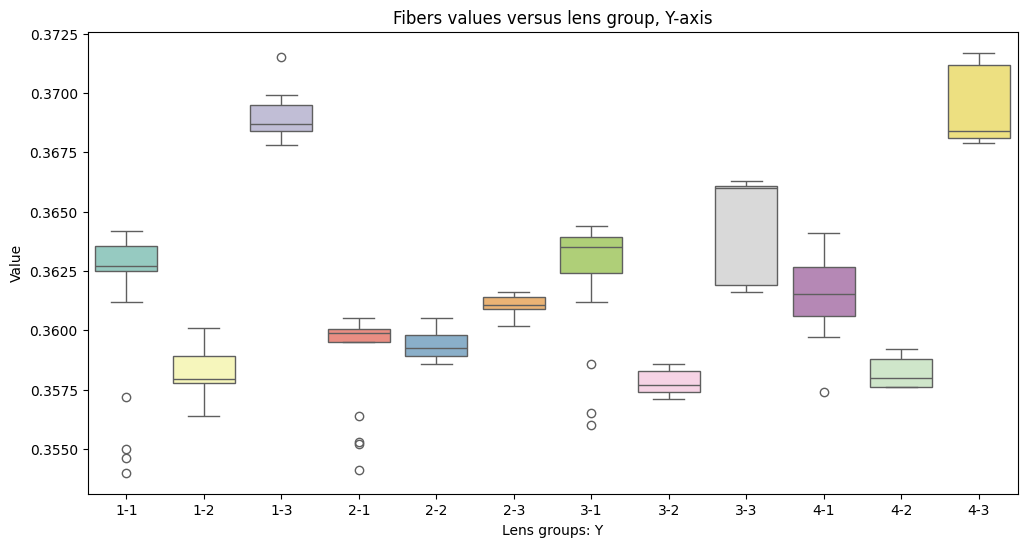

In [16]:
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, X-axis", xlabel="Lens groups: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, Y-axis", xlabel="Lens groups: ", ylabel="Value", filter="Y", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

In [22]:
######Terminar
##Data export
date = get_date()
name_xlsx = glob.tooling + "_EDA_" + get_date() + ".xlsx"
name_scatter = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_scatter_" + date + ".pdf"
name_bloxplot = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_boxplot_" + date + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.abspath("../a2_output/reports")
    DATA = pd.concat([MEAS_format, LIMITS_format], axis=1)
    plot_to_pdf(MEAS, name=name_scatter, plot="SCATTER")
    plot_to_pdf([MEAS_format, FIXTURE_DATA], name=name_bloxplot, plot="BOXPLOT")
    output_html([FIXTURE_DATA, MEAS_format, LIMITS_format, RESUME_format, LARGEST, DATA_FILTERED], "EDA.html")
    output_html([DATA_FILTERED], "Values.html")
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output
